#Transformer + Pos Tag
Código basado en https://towardsdatascience.com/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1

---
## Imports

In [2]:
!pip install torch numpy matplotlib

In [3]:
import torch
import torch.nn as nn

import random
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Datasets

## Vocabs

Vocabulario del part of speech

In [16]:
in_vocab = [
    "<pad>",
    "<unk>",
    "<sos>",
    "<eos>",
    "run",
    "opposite",
    "right",
    "after",
    "turn",
    "left",
    "twice",
    "around",
    "thrice",
    "walk",
    "jump",
    "and",
    "look",
]

out_vocab = [
    "<pad>",
    "<unk>",
    "<sos>",
    "<eos>",
    "I_TURN_LEFT",
    "I_TURN_RIGHT",
    "I_RUN",
    "I_WALK",
    "I_JUMP",
    "I_LOOK",
]

pos_vocab = [
    "<pad>",
    "<unk>",
    "<sos>",
    "<eos>",
    "ADV",
    "CNJ",
    "DIR",
    "MOD",
    "VRB",
]

pos_map = {
    "<sos>": "<sos>",
    "<eos>": "<eos>",
    "run": "VRB",
    "turn": "VRB",
    "walk": "VRB",
    "jump": "VRB",
    "look": "VRB",
    "right": "DIR",
    "left": "DIR",
    "twice": "ADV",
    "thrice": "ADV",
    "opposite": "MOD",
    "around": "MOD",
    "after": "CNJ",
    "and": "CNJ",
}


## Dataloader

In [17]:
import re
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

In [18]:
class SCAN(Dataset):
    def __init__(self, path, transform=None, command_len=None, action_len=None):
        self.data = []
        self.transform = transform
        self.max_command_len = 0
        self.max_action_len = 0

        # Cargar los datos
        with open(path) as ar:
            for line in ar:
                x, y = re.findall(r"^IN: (.+) OUT: (.+)$", line.strip())[0]

                x, y = x.split(), y.split()

                x = ["<sos>"] + x + ["<eos>"]
                y = ["<sos>"] + y + ["<eos>"]
                p = [pos_map[i] for i in x]

                self.data.append({"command": x, "pos": p, "actions": y})
                self.max_command_len = max(self.max_command_len, len(x))
                self.max_action_len = max(self.max_action_len, len(y))

        if command_len is not None:
            self.max_command_len = command_len

        if action_len is not None:
            self.max_action_len = action_len

        # Hacer padding
        for i, data in enumerate(self.data):
            padded_comm = self.pad(data["command"], self.max_command_len)
            padded_pos = self.pad(data["pos"], self.max_command_len)
            padded_act = self.pad(data["actions"], self.max_action_len)
            self.data[i] = self.transform({"command": padded_comm, "pos": padded_pos, "actions": padded_act})

    @staticmethod
    def pad(item, length):
        return item + ["<pad>" for _ in range(length - len(item))]

    def __getitem__(self, idx):
        return self.data[idx]

    def __len__(self):
        return len(self.data)

    @staticmethod
    def decode(batch, vocab):
        pad_idx = vocab.index("<pad>")
        strs = []
        for item in batch:
            s = " ".join([vocab[i] for i in item if i != pad_idx])
            strs.append(s)
        return strs

In [19]:
def collate_fn(samples):
    return {
        "command": torch.stack([s["command"] for s in samples]),
        "pos": torch.stack([s["pos"] for s in samples]),
        "actions": torch.stack([s["actions"] for s in samples]),
    }

In [20]:
def get_dataloader(path, batch_size, transform=None):
    dataset = SCAN(path, transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

In [21]:
def get_vocab_transform(in_vocab: list, out_vocab: list, pos_vocab: list):
    in_vocab = {token: i for i, token in enumerate(in_vocab)}
    out_vocab = {token: i for i, token in enumerate(out_vocab)}
    pos_vocab = {token: i for i, token in enumerate(pos_vocab)}

    def transform(data: dict):
        com, pos, act = data["command"], data["pos"], data["actions"]
        com = [in_vocab[token] for token in com]
        pos = [pos_vocab[token] for token in pos]
        act = [out_vocab[token] for token in act]

        return {
            "command": torch.tensor(com),
            "pos": torch.tensor(pos),
            "actions": torch.tensor(act),
        }

    return transform

Modo de uso:

```py
path = "./data/tasks_train_addprim_jump.txt"
train_loader = get_dataloader(path, batch_size, transform=get_vocab_transform(in_vocab, out_vocab, pos_vocab))

# cada item es de la forma
{
    "command": [...], # shape: (batch_size, in_seq_len)
    "pos": [...], # shape: (batch_size, in_seq_len)
    "actions": [...], # shape: (batch_size, out_seq_len)
```


In [ ]:
%cd ..

/content


In [22]:
!wget https://github.com/brendenlake/SCAN/raw/master/simple_split/tasks_train_simple.txt
!wget https://github.com/brendenlake/SCAN/raw/master/simple_split/tasks_test_simple.txt
!wget https://github.com/brendenlake/SCAN/raw/master/add_prim_split/tasks_train_addprim_jump.txt
!wget https://github.com/brendenlake/SCAN/raw/master/add_prim_split/tasks_test_addprim_jump.txt
!wget https://github.com/SegwangKim/SCAN/raw/master/mcd_split/tasks_train_mcd1.txt
!wget https://github.com/SegwangKim/SCAN/raw/master/mcd_split/tasks_test_mcd1.txt

--2021-12-21 19:03:12--  https://github.com/brendenlake/SCAN/raw/master/simple_split/tasks_train_simple.txt
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/brendenlake/SCAN/master/simple_split/tasks_train_simple.txt [following]
--2021-12-21 19:03:13--  https://raw.githubusercontent.com/brendenlake/SCAN/master/simple_split/tasks_train_simple.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3267938 (3.1M) [text/plain]
Saving to: ‘tasks_train_simple.txt’

tasks_train_simple. 100%[===================>]   3.12M  --.-KB/s    in 0.07s   

2021-12-21 19:03:13 (45.0 MB/s) - ‘tasks_train_simple.txt’ sa

In [23]:
%cd "/content/drive/Shareddrives/TextMining/checkpoints"

/content/drive/Shareddrives/TextMining/checkpoints


In [24]:
BATCH_SIZE=256
DATASET_SPLIT="addprim_jump"
train_dataloader = get_dataloader(f'/content/tasks_train_{DATASET_SPLIT}.txt', BATCH_SIZE, transform=get_vocab_transform(in_vocab, out_vocab, pos_vocab))
val_dataloader = get_dataloader(f'/content/tasks_test_{DATASET_SPLIT}.txt', BATCH_SIZE, transform=get_vocab_transform(in_vocab, out_vocab, pos_vocab))

# Transformer

Primero se define el positional encoding del transformer

In [25]:
class PositionalEncoding(nn.Module):
    def __init__(self, dim_model, dropout_p, max_len):
        super().__init__()
        # Modified version from: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
        # max_len determines how far the position can have an effect on a token (window)
        
        # Info
        self.dropout = nn.Dropout(dropout_p)
        
        # Encoding - From formula
        pos_encoding = torch.zeros(max_len, dim_model)
        positions_list = torch.arange(0, max_len, dtype=torch.float).view(-1, 1) # 0, 1, 2, 3, 4, 5
        division_term = torch.exp(torch.arange(0, dim_model, 2).float() * (-math.log(10000.0)) / dim_model) # 1000^(2i/dim_model)
        
        # PE(pos, 2i) = sin(pos/1000^(2i/dim_model))
        pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)
        
        # PE(pos, 2i + 1) = cos(pos/1000^(2i/dim_model))
        pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)
        
        # Saving buffer (same as parameter without gradients needed)
        pos_encoding = pos_encoding.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pos_encoding",pos_encoding)
        
    def forward(self, token_embedding: torch.tensor) -> torch.tensor:
        # Residual connection + pos encoding
        return self.dropout(token_embedding + self.pos_encoding[:token_embedding.size(0), :])

Luego creamos la clase transformer

In [26]:
class Transformer(nn.Module):
    """
    Model from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/p/c80afbc9ffb1/
    """

    # Constructor
    def __init__(
        self,
        num_tokens_in,
        num_tokens_out,
        dim_model,
        num_heads,
        num_encoder_layers,
        num_decoder_layers,
        dropout_p,
        use_pos_tag=False,
        pos_vocab_size=None,
    ):
        super().__init__()

        # INFO
        self.model_type = "Transformer"
        self.dim_model = dim_model

        # LAYERS
        self.positional_encoder = PositionalEncoding(dim_model=dim_model, dropout_p=dropout_p, max_len=5000)
        self.embedding_in = nn.Embedding(num_tokens_in, dim_model)
        self.embedding_out = nn.Embedding(num_tokens_out, dim_model)

        encoder_layer = nn.TransformerEncoderLayer(d_model=dim_model, nhead=num_heads)
        encoder_norm = nn.LayerNorm(dim_model)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers, norm=encoder_norm)

        decoder_layer = nn.TransformerDecoderLayer(d_model=dim_model, nhead=num_heads)
        decoder_norm = nn.LayerNorm(dim_model)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_decoder_layers, decoder_norm)

        self.out = nn.Linear(dim_model, num_tokens_out)

        self.use_pos_tag = use_pos_tag
        if use_pos_tag:
            self.pos_linear = nn.Linear(dim_model, pos_vocab_size)

    def forward(self, src, tgt, tgt_mask=None, src_pad_mask=None, tgt_pad_mask=None):
        # Src size must be (batch_size, src sequence length)
        # Tgt size must be (batch_size, tgt sequence length)

        # Embedding + positional encoding - Out size = (batch_size, sequence length, dim_model)
        src = self.embedding_in(src) * math.sqrt(self.dim_model)
        tgt = self.embedding_out(tgt) * math.sqrt(self.dim_model)
        src = self.positional_encoder(src)
        tgt = self.positional_encoder(tgt)

        # We could use the parameter batch_first=True, but our KDL version doesn't support it yet, so we permute
        # to obtain size (sequence length, batch_size, dim_model),
        src = src.permute(1, 0, 2)
        tgt = tgt.permute(1, 0, 2)

        # Transformer blocks - Out size = (sequence length, batch_size, num_tokens)
        enc_out = self.encoder(src, src_key_padding_mask=src_pad_mask)
        dec_out = self.decoder(tgt, enc_out, tgt_mask=tgt_mask, tgt_key_padding_mask=tgt_pad_mask)

        out = self.out(dec_out)

        if self.use_pos_tag:
            pos_out = self.pos_linear(enc_out)
            return out, pos_out

        return out

    def get_tgt_mask(self, size) -> torch.tensor:
        # Generates a squeare matrix where the each row allows one word more to be seen
        mask = torch.tril(torch.ones(size, size) == 1)  # Lower triangular matrix
        mask = mask.float()
        mask = mask.masked_fill(mask == 0, float("-inf"))  # Convert zeros to -inf
        mask = mask.masked_fill(mask == 1, float(0.0))  # Convert ones to 0

        # EX for size=5:
        # [[0., -inf, -inf, -inf, -inf],
        #  [0.,   0., -inf, -inf, -inf],
        #  [0.,   0.,   0., -inf, -inf],
        #  [0.,   0.,   0.,   0., -inf],
        #  [0.,   0.,   0.,   0.,   0.]]

        return mask

    def create_pad_mask(self, matrix: torch.tensor, pad_token: int) -> torch.tensor:
        # If matrix = [1,2,3,0,0,0] where pad_token=0, the result mask is
        # [False, False, False, True, True, True]
        return matrix == pad_token


Seteamos los hiperparámetros del modelo

In [27]:
dim_model = 128
num_heads = 4
num_layers = 3

La siguiente celda es para crear un Transformer + Pos Tag

In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_pos = Transformer(
    num_tokens_in=len(in_vocab) + 2,
    num_tokens_out=len(out_vocab) + 2,
    dim_model=dim_model,
    num_heads=num_heads,
    num_encoder_layers=num_layers,
    num_decoder_layers=num_layers,
    dropout_p=0.1,
    use_pos_tag=True,
    pos_vocab_size=len(pos_vocab) + 2,
).to(device)
opt_pos = torch.optim.SGD(model_pos.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss(ignore_index=0)
for p in model_pos.parameters():
      if p.dim() > 1:
          nn.init.xavier_uniform_(p)


Y esta celda de abajo es para crear un Transformer sin pos tag

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Transformer(
    num_tokens_in=len(in_vocab) + 2,
    num_tokens_out=len(out_vocab) + 2,
    dim_model=dim_model,
    num_heads=num_heads,
    num_encoder_layers=num_layers,
    num_decoder_layers=num_layers,
    dropout_p=0.1
).to(device)
opt = torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss(ignore_index=0)
for p in model.parameters():
      if p.dim() > 1:
          nn.init.xavier_uniform(p)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  from ipykernel import kernelapp as app


In [29]:
PAD_TOKEN = 0 # Cambiar con el pad token verdadero

Definimos la métrica de accuracy. Notar que no se toman en cuenta los items de padding

In [30]:
def accuracy(y_true: torch.Tensor, y_pred: torch.Tensor, pad_idx=0):
    mask = y_true != pad_idx

    #print(y_true.shape, y_pred.shape, y_pred.argmax(dim=-1).shape)
    acc = (y_true == y_pred.argmax(dim=1)) * mask
    return torch.sum(acc).item() / torch.sum(mask).item()

In [31]:
def get_checkpoint_fn(init_best_val_loss = float('inf'), init_best_val_acc = 0):
    best_val_loss = init_best_val_loss
    best_val_acc = init_best_val_acc
    def checkpoint_fn(model, optimizer, loss, acc, epoch, name):
        nonlocal best_val_loss, best_val_acc

        name = f'{DATASET_SPLIT}-{name}'
        to_save = {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch,
            'val_loss': loss,
            'val_acc': acc
        }

        if loss < best_val_loss:
            best_val_loss = loss
            torch.save(to_save, f'./{name}-best_val_loss')
            print(f'Saved best val loss')

        if acc > best_val_acc:
            best_val_acc = acc
            torch.save(to_save, f'./{name}-best_val_acc')
            print(f'Saved best val acc')

    return checkpoint_fn

In [32]:
def train_loop(model, opt, loss_fn, dataloader):
    model.train()
    total_loss = 0
    
    for batch in tqdm(dataloader):
        X = batch['command'].to(device)
        y = batch['actions'].to(device)

        # Now we shift the tgt by one so with the <SOS> we predict the token at pos 1
        y_input = y[:,:-1]
        y_expected = y[:,1:]
        
        # Get mask to mask out the next words
        sequence_length = y_input.size(1)
        tgt_mask = model.get_tgt_mask(sequence_length).to(device)

        # Obtener la máscara del padding del input
        X_mask = model.create_pad_mask(X, PAD_TOKEN)
        Y_mask = model.create_pad_mask(y_input, PAD_TOKEN)

        # Standard training except we pass in y_input and tgt_mask
        pred = model(X, y_input, tgt_mask, src_pad_mask=X_mask, tgt_pad_mask=Y_mask)

        # Permute pred to have batch size first again
        pred = pred.permute(1, 2, 0)      
        loss = loss_fn(pred, y_expected)

        opt.zero_grad()
        loss.backward()
        opt.step()
    
        total_loss += loss.detach().item()
        
    return total_loss / len(dataloader)


def train_loop_pos(model, opt, loss_fn, dataloader):
    model.train()
    total_loss = 0
    
    for batch in tqdm(dataloader):
        X = batch['command'].to(device)
        y = batch['actions'].to(device)
        p = batch['pos'].to(device)

        # Now we shift the tgt by one so with the <SOS> we predict the token at pos 1
        y_input = y[:,:-1]
        y_expected = y[:,1:]
        
        # Get mask to mask out the next words
        sequence_length = y_input.size(1)
        tgt_mask = model.get_tgt_mask(sequence_length).to(device)

        # Obtener la máscara del padding del input
        X_mask = model.create_pad_mask(X, PAD_TOKEN)
        Y_mask = model.create_pad_mask(y_input, PAD_TOKEN)

        # Standard training except we pass in y_input and tgt_mask
        pred, pos_pred = model(X, y_input, tgt_mask, src_pad_mask=X_mask, tgt_pad_mask=Y_mask)

        # Permute pred to have batch size first again
        pred = pred.permute(1, 2, 0)      
        pos_pred = pos_pred.permute(1, 2, 0)
        # print(pred.shape, y_expected.shape)
        # print(pos_pred.shape, p.shape)
        # print(p)
        loss = loss_fn(pred, y_expected)
        loss += 0.1 * loss_fn(pos_pred, p)

        opt.zero_grad()
        loss.backward()
        opt.step()
    
        total_loss += loss.detach().item()
        
    return total_loss / len(dataloader)

In [33]:
def validation_loop(model, loss_fn, dataloader):
    model.eval()
    total_loss = 0
    acc = 0
    
    with torch.no_grad():
        for batch in tqdm(dataloader):
            X = batch['command'].to(device)
            y = batch['actions'].to(device)

            # Now we shift the tgt by one so with the <SOS> we predict the token at pos 1
            y_input = y[:,:-1]
            y_expected = y[:,1:]
            
            # Get mask to mask out the next words
            sequence_length = y_input.size(1)
            tgt_mask = model.get_tgt_mask(sequence_length).to(device)

            # Standard training except we pass in y_input and src_mask
            pred = model(X, y_input, tgt_mask)

            # Permute pred to have batch size first again
            pred = pred.permute(1, 2, 0)      
            loss = loss_fn(pred, y_expected)
            total_loss += loss.detach().item()

            acc += accuracy(y_expected, pred)
        
    return total_loss / len(dataloader), acc/len(dataloader)

def validation_loop_pos(model, loss_fn, dataloader):
    model.eval()
    total_loss = 0
    acc = 0
    pos_acc = 0
    
    with torch.no_grad():
        for batch in tqdm(dataloader):
            X = batch['command'].to(device)
            y = batch['actions'].to(device)
            p = batch['pos'].to(device)
            # Now we shift the tgt by one so with the <SOS> we predict the token at pos 1
            y_input = y[:,:-1]
            y_expected = y[:,1:]
            
            # Get mask to mask out the next words
            sequence_length = y_input.size(1)
            tgt_mask = model.get_tgt_mask(sequence_length).to(device)

            # Standard training except we pass in y_input and src_mask
            pred, pos_pred = model(X, y_input, tgt_mask)

            # Permute pred to have batch size first again
            pred = pred.permute(1, 2, 0)      
            pos_pred = pos_pred.permute(1, 2, 0)      
            loss = loss_fn(pred, y_expected)
            loss += loss_fn(pos_pred, p)
            total_loss += loss.detach().item()

            acc += accuracy(y_expected, pred)
            pos_acc += accuracy(p, pos_pred)
        
    return total_loss / len(dataloader), acc/len(dataloader), pos_acc/len(dataloader)

El siguiente fit es para entrenar un modelo SIN POS

In [ ]:
def fit(model, opt, loss_fn, train_dataloader, val_dataloader, epochs):
    # Used for plotting later on
    model = model.to(device)
    loss_fn = loss_fn.to(device)
    train_loss_list, validation_loss_list, validation_accuracy_list = [], [], []
    checkpoint_fn = get_checkpoint_fn()
    
    print("Training and validating model")
    for epoch in range(epochs):
        print("-"*25, f"Epoch {epoch + 1}","-"*25)
        
        train_loss = train_loop(model, opt, loss_fn, train_dataloader)
        train_loss_list += [train_loss]
        
        validation_loss, validation_accuracy = validation_loop(model, loss_fn, val_dataloader)
        validation_loss_list += [validation_loss]
        validation_accuracy_list += [validation_accuracy]
        
        #print(f"Training loss: {train_loss:.4f}")
        print(f"Validation loss: {validation_loss:.4f}")
        print(f"Validation Accuracy: {validation_accuracy:.4f}")

        checkpoint_fn(model, opt, validation_loss, validation_accuracy, epoch, f'no_pos-dim({dim_model})-heads({num_heads})')

        print()
        
    return train_loss_list, validation_loss_list, validation_accuracy_list
    
train_loss_list, validation_loss_list, validation_accuracy_list = fit(model, opt, loss_fn, train_dataloader, val_dataloader, 50)

Training and validating model
------------------------- Epoch 1 -------------------------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 1.4725
Validation Accuracy: 0.5113
Saved best val loss
Saved best val acc

------------------------- Epoch 2 -------------------------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 1.3129
Validation Accuracy: 0.5445
Saved best val loss
Saved best val acc

------------------------- Epoch 3 -------------------------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 1.2021
Validation Accuracy: 0.5740
Saved best val loss
Saved best val acc

------------------------- Epoch 4 -------------------------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 1.1739
Validation Accuracy: 0.5786
Saved best val loss
Saved best val acc

------------------------- Epoch 5 -------------------------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 1.1156
Validation Accuracy: 0.5881
Saved best val loss
Saved best val acc

------------------------- Epoch 6 -------------------------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 1.1760
Validation Accuracy: 0.5747

------------------------- Epoch 7 -------------------------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 1.0386
Validation Accuracy: 0.6168
Saved best val loss
Saved best val acc

------------------------- Epoch 8 -------------------------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 1.0572
Validation Accuracy: 0.6164

------------------------- Epoch 9 -------------------------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 1.0806
Validation Accuracy: 0.6070

------------------------- Epoch 10 -------------------------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 1.0370
Validation Accuracy: 0.6044
Saved best val loss

------------------------- Epoch 11 -------------------------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 1.0223
Validation Accuracy: 0.6203
Saved best val loss
Saved best val acc

------------------------- Epoch 12 -------------------------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 1.0216
Validation Accuracy: 0.6315
Saved best val loss
Saved best val acc

------------------------- Epoch 13 -------------------------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 1.0104
Validation Accuracy: 0.6224
Saved best val loss

------------------------- Epoch 14 -------------------------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 0.9841
Validation Accuracy: 0.6340
Saved best val loss
Saved best val acc

------------------------- Epoch 15 -------------------------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 0.9265
Validation Accuracy: 0.6476
Saved best val loss
Saved best val acc

------------------------- Epoch 16 -------------------------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 0.9500
Validation Accuracy: 0.6454

------------------------- Epoch 17 -------------------------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 1.0001
Validation Accuracy: 0.6375

------------------------- Epoch 18 -------------------------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 0.9614
Validation Accuracy: 0.6390

------------------------- Epoch 19 -------------------------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 0.9105
Validation Accuracy: 0.6508
Saved best val loss
Saved best val acc

------------------------- Epoch 20 -------------------------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 0.9573
Validation Accuracy: 0.6444

------------------------- Epoch 21 -------------------------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 0.9317
Validation Accuracy: 0.6384

------------------------- Epoch 22 -------------------------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 0.9316
Validation Accuracy: 0.6556
Saved best val acc

------------------------- Epoch 23 -------------------------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 0.9051
Validation Accuracy: 0.6578
Saved best val loss
Saved best val acc

------------------------- Epoch 24 -------------------------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 0.9141
Validation Accuracy: 0.6527

------------------------- Epoch 25 -------------------------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 0.8952
Validation Accuracy: 0.6520
Saved best val loss

------------------------- Epoch 26 -------------------------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 0.8768
Validation Accuracy: 0.6667
Saved best val loss
Saved best val acc

------------------------- Epoch 27 -------------------------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 0.8896
Validation Accuracy: 0.6581

------------------------- Epoch 28 -------------------------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 0.8853
Validation Accuracy: 0.6588

------------------------- Epoch 29 -------------------------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 0.8791
Validation Accuracy: 0.6593

------------------------- Epoch 30 -------------------------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 0.8883
Validation Accuracy: 0.6484

------------------------- Epoch 31 -------------------------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 0.8693
Validation Accuracy: 0.6619
Saved best val loss

------------------------- Epoch 32 -------------------------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 0.8943
Validation Accuracy: 0.6628

------------------------- Epoch 33 -------------------------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 0.8801
Validation Accuracy: 0.6646

------------------------- Epoch 34 -------------------------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 0.8728
Validation Accuracy: 0.6664

------------------------- Epoch 35 -------------------------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 0.8575
Validation Accuracy: 0.6735
Saved best val loss
Saved best val acc

------------------------- Epoch 36 -------------------------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 0.8725
Validation Accuracy: 0.6713

------------------------- Epoch 37 -------------------------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 0.8693
Validation Accuracy: 0.6589

------------------------- Epoch 38 -------------------------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 0.8433
Validation Accuracy: 0.6688
Saved best val loss

------------------------- Epoch 39 -------------------------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 0.8191
Validation Accuracy: 0.6856
Saved best val loss
Saved best val acc

------------------------- Epoch 40 -------------------------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 0.8515
Validation Accuracy: 0.6797

------------------------- Epoch 41 -------------------------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 0.8630
Validation Accuracy: 0.6658

------------------------- Epoch 42 -------------------------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 0.8501
Validation Accuracy: 0.6696

------------------------- Epoch 43 -------------------------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 0.8925
Validation Accuracy: 0.6511

------------------------- Epoch 44 -------------------------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 0.8590
Validation Accuracy: 0.6691

------------------------- Epoch 45 -------------------------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 0.8372
Validation Accuracy: 0.6775

------------------------- Epoch 46 -------------------------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 0.8447
Validation Accuracy: 0.6799

------------------------- Epoch 47 -------------------------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 0.8738
Validation Accuracy: 0.6704

------------------------- Epoch 48 -------------------------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 0.8342
Validation Accuracy: 0.6714

------------------------- Epoch 49 -------------------------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 0.8394
Validation Accuracy: 0.6796

------------------------- Epoch 50 -------------------------


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss: 0.8783
Validation Accuracy: 0.6691



El siguiente fit es para entrenar un modelo CON POS

In [34]:
def fit_pos(model, opt, loss_fn, train_dataloader, val_dataloader, epochs):
    # Used for plotting later on
    model = model.to(device)
    loss_fn = loss_fn.to(device)
    train_loss_list, validation_loss_list, validation_accuracy_list, validation_pos_accuracy_list = [], [], [], []
    checkpoint_fn = get_checkpoint_fn()
    
    print("Training and validating model")
    for epoch in range(epochs):
        print("-"*25, f"Epoch {epoch + 1}","-"*25)
        
        train_loss = train_loop_pos(model, opt, loss_fn, train_dataloader)
        train_loss_list += [train_loss]
        
        validation_loss, validation_accuracy, validation_pos_accuracy = validation_loop_pos(model, loss_fn, val_dataloader)
        validation_loss_list += [validation_loss]
        validation_accuracy_list += [validation_accuracy]
        validation_pos_accuracy_list += [validation_pos_accuracy]
        
        print(f"Training loss: {train_loss:.4f}")
        print(f"Validation loss: {validation_loss:.4f}")
        print(f"Validation Accuracy: {validation_accuracy:.4f}")
        print(f"Validation Pos Accuracy: {validation_pos_accuracy:.4f}")

        checkpoint_fn(model, opt, validation_loss, validation_accuracy, epoch, f'pos_aux-dim({dim_model})-heads({num_heads})')

        print()
        
    return train_loss_list, validation_loss_list, validation_accuracy_list, validation_pos_accuracy_list
    
train_loss_list, validation_loss_list, validation_accuracy_list, validation_pos_accuracy_list = fit_pos(model_pos, opt_pos, loss_fn, train_dataloader, val_dataloader, 50)

Training and validating model
------------------------- Epoch 1 -------------------------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Training loss: 1.5970
Validation loss: 3.4723
Validation Accuracy: 0.4868
Validation Pos Accuracy: 0.5938
Saved best val loss
Saved best val acc

------------------------- Epoch 2 -------------------------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Training loss: 1.1249
Validation loss: 2.8779
Validation Accuracy: 0.5070
Validation Pos Accuracy: 0.9017
Saved best val loss
Saved best val acc

------------------------- Epoch 3 -------------------------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Training loss: 0.9830
Validation loss: 2.7544
Validation Accuracy: 0.5086
Validation Pos Accuracy: 0.9556
Saved best val loss
Saved best val acc

------------------------- Epoch 4 -------------------------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Training loss: 0.9080
Validation loss: 2.6441
Validation Accuracy: 0.5245
Validation Pos Accuracy: 0.9705
Saved best val loss
Saved best val acc

------------------------- Epoch 5 -------------------------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Training loss: 0.8599
Validation loss: 2.6855
Validation Accuracy: 0.5220
Validation Pos Accuracy: 0.9801

------------------------- Epoch 6 -------------------------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Training loss: 0.8293
Validation loss: 2.6484
Validation Accuracy: 0.5321
Validation Pos Accuracy: 0.9874
Saved best val acc

------------------------- Epoch 7 -------------------------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Training loss: 0.8036
Validation loss: 2.5952
Validation Accuracy: 0.5390
Validation Pos Accuracy: 0.9911
Saved best val loss
Saved best val acc

------------------------- Epoch 8 -------------------------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Training loss: 0.7804
Validation loss: 2.6142
Validation Accuracy: 0.5358
Validation Pos Accuracy: 0.9928

------------------------- Epoch 9 -------------------------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Training loss: 0.7620
Validation loss: 2.6137
Validation Accuracy: 0.5396
Validation Pos Accuracy: 0.9949
Saved best val acc

------------------------- Epoch 10 -------------------------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Training loss: 0.7452
Validation loss: 2.6004
Validation Accuracy: 0.5344
Validation Pos Accuracy: 0.9970

------------------------- Epoch 11 -------------------------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Training loss: 0.7278
Validation loss: 2.5913
Validation Accuracy: 0.5359
Validation Pos Accuracy: 0.9979
Saved best val loss

------------------------- Epoch 12 -------------------------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Training loss: 0.7113
Validation loss: 2.5774
Validation Accuracy: 0.5391
Validation Pos Accuracy: 0.9984
Saved best val loss

------------------------- Epoch 13 -------------------------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Training loss: 0.7011
Validation loss: 2.5974
Validation Accuracy: 0.5393
Validation Pos Accuracy: 0.9991

------------------------- Epoch 14 -------------------------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Training loss: 0.6892
Validation loss: 2.5861
Validation Accuracy: 0.5350
Validation Pos Accuracy: 0.9993

------------------------- Epoch 15 -------------------------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Training loss: 0.6780
Validation loss: 2.5776
Validation Accuracy: 0.5419
Validation Pos Accuracy: 0.9996
Saved best val acc

------------------------- Epoch 16 -------------------------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Training loss: 0.6712
Validation loss: 2.6001
Validation Accuracy: 0.5294
Validation Pos Accuracy: 0.9996

------------------------- Epoch 17 -------------------------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Training loss: 0.6589
Validation loss: 2.6198
Validation Accuracy: 0.5246
Validation Pos Accuracy: 0.9999

------------------------- Epoch 18 -------------------------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Training loss: 0.6500
Validation loss: 2.5813
Validation Accuracy: 0.5337
Validation Pos Accuracy: 1.0000

------------------------- Epoch 19 -------------------------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Training loss: 0.6445
Validation loss: 2.5754
Validation Accuracy: 0.5334
Validation Pos Accuracy: 1.0000
Saved best val loss

------------------------- Epoch 20 -------------------------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Training loss: 0.6385
Validation loss: 2.5600
Validation Accuracy: 0.5360
Validation Pos Accuracy: 1.0000
Saved best val loss

------------------------- Epoch 21 -------------------------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Training loss: 0.6301
Validation loss: 2.5953
Validation Accuracy: 0.5258
Validation Pos Accuracy: 1.0000

------------------------- Epoch 22 -------------------------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Training loss: 0.6242
Validation loss: 2.5773
Validation Accuracy: 0.5327
Validation Pos Accuracy: 1.0000

------------------------- Epoch 23 -------------------------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Training loss: 0.6162
Validation loss: 2.6006
Validation Accuracy: 0.5208
Validation Pos Accuracy: 1.0000

------------------------- Epoch 24 -------------------------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Training loss: 0.6134
Validation loss: 2.5770
Validation Accuracy: 0.5361
Validation Pos Accuracy: 1.0000

------------------------- Epoch 25 -------------------------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Training loss: 0.6081
Validation loss: 2.6183
Validation Accuracy: 0.5276
Validation Pos Accuracy: 1.0000

------------------------- Epoch 26 -------------------------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Training loss: 0.6029
Validation loss: 2.6098
Validation Accuracy: 0.5296
Validation Pos Accuracy: 1.0000

------------------------- Epoch 27 -------------------------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Training loss: 0.5997
Validation loss: 2.6053
Validation Accuracy: 0.5296
Validation Pos Accuracy: 1.0000

------------------------- Epoch 28 -------------------------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Training loss: 0.5956
Validation loss: 2.6148
Validation Accuracy: 0.5212
Validation Pos Accuracy: 1.0000

------------------------- Epoch 29 -------------------------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Training loss: 0.5918
Validation loss: 2.5695
Validation Accuracy: 0.5446
Validation Pos Accuracy: 1.0000
Saved best val acc

------------------------- Epoch 30 -------------------------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Training loss: 0.5882
Validation loss: 2.5905
Validation Accuracy: 0.5385
Validation Pos Accuracy: 1.0000

------------------------- Epoch 31 -------------------------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Training loss: 0.5831
Validation loss: 2.5969
Validation Accuracy: 0.5359
Validation Pos Accuracy: 1.0000

------------------------- Epoch 32 -------------------------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Training loss: 0.5815
Validation loss: 2.6265
Validation Accuracy: 0.5244
Validation Pos Accuracy: 1.0000

------------------------- Epoch 33 -------------------------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Training loss: 0.5791
Validation loss: 2.6052
Validation Accuracy: 0.5328
Validation Pos Accuracy: 1.0000

------------------------- Epoch 34 -------------------------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Training loss: 0.5743
Validation loss: 2.6310
Validation Accuracy: 0.5261
Validation Pos Accuracy: 1.0000

------------------------- Epoch 35 -------------------------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Training loss: 0.5718
Validation loss: 2.6050
Validation Accuracy: 0.5324
Validation Pos Accuracy: 1.0000

------------------------- Epoch 36 -------------------------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Training loss: 0.5687
Validation loss: 2.6167
Validation Accuracy: 0.5395
Validation Pos Accuracy: 1.0000

------------------------- Epoch 37 -------------------------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Training loss: 0.5665
Validation loss: 2.6217
Validation Accuracy: 0.5367
Validation Pos Accuracy: 1.0000

------------------------- Epoch 38 -------------------------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Training loss: 0.5633
Validation loss: 2.6328
Validation Accuracy: 0.5353
Validation Pos Accuracy: 1.0000

------------------------- Epoch 39 -------------------------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Training loss: 0.5612
Validation loss: 2.6314
Validation Accuracy: 0.5313
Validation Pos Accuracy: 1.0000

------------------------- Epoch 40 -------------------------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Training loss: 0.5593
Validation loss: 2.6570
Validation Accuracy: 0.5212
Validation Pos Accuracy: 1.0000

------------------------- Epoch 41 -------------------------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Training loss: 0.5559
Validation loss: 2.6072
Validation Accuracy: 0.5422
Validation Pos Accuracy: 1.0000

------------------------- Epoch 42 -------------------------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Training loss: 0.5540
Validation loss: 2.6380
Validation Accuracy: 0.5284
Validation Pos Accuracy: 1.0000

------------------------- Epoch 43 -------------------------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Training loss: 0.5532
Validation loss: 2.6388
Validation Accuracy: 0.5377
Validation Pos Accuracy: 1.0000

------------------------- Epoch 44 -------------------------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Training loss: 0.5486
Validation loss: 2.6444
Validation Accuracy: 0.5347
Validation Pos Accuracy: 1.0000

------------------------- Epoch 45 -------------------------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Training loss: 0.5473
Validation loss: 2.6702
Validation Accuracy: 0.5285
Validation Pos Accuracy: 1.0000

------------------------- Epoch 46 -------------------------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Training loss: 0.5462
Validation loss: 2.6660
Validation Accuracy: 0.5331
Validation Pos Accuracy: 1.0000

------------------------- Epoch 47 -------------------------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Training loss: 0.5458
Validation loss: 2.6697
Validation Accuracy: 0.5369
Validation Pos Accuracy: 1.0000

------------------------- Epoch 48 -------------------------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Training loss: 0.5416
Validation loss: 2.6742
Validation Accuracy: 0.5317
Validation Pos Accuracy: 1.0000

------------------------- Epoch 49 -------------------------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Training loss: 0.5390
Validation loss: 2.6404
Validation Accuracy: 0.5404
Validation Pos Accuracy: 1.0000

------------------------- Epoch 50 -------------------------


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Training loss: 0.5385
Validation loss: 2.6395
Validation Accuracy: 0.5450
Validation Pos Accuracy: 1.0000
Saved best val acc



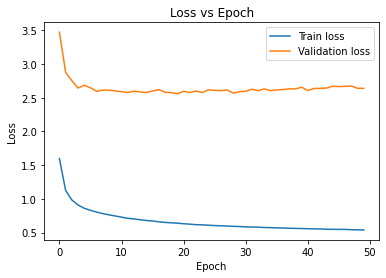

In [37]:
plt.plot(train_loss_list, label = "Train loss")
plt.plot(validation_loss_list, label = "Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

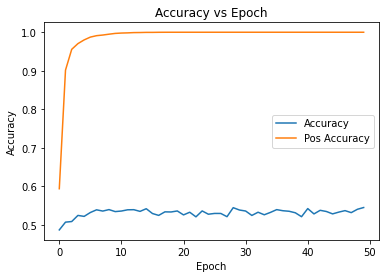

In [36]:
plt.plot(validation_accuracy_list, label = "Accuracy")
plt.plot(validation_pos_accuracy_list, label = "Pos Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.show()

Funcion para predecir

In [ ]:
def predict(model, input_sequence, max_length=50, SOS_token=2, EOS_token=3):
    model.eval()

    y_input = torch.tensor([[SOS_token]], dtype=torch.long, device=device)

    num_tokens = len(inputsequence[0])

    for  in range(max_length):
        # Get source mask
        tgt_mask = model.get_tgt_mask(y_input.size(1)).to(device)

        pred = model(input_sequence, y_input, tgt_mask)

        if isinstance(pred, tuple):
            pred = pred[0]

        next_item = pred.topk(1)[1].view(-1)[-1].item() # num with highest probability
        next_item = torch.tensor([[next_item]], device=device)

        # Concatenate previous input with predicted best word
        y_input = torch.cat((y_input, next_item), dim=1)

        # Stop if model predicts end of sentence
        if next_item.view(-1).item() == EOS_token:
            break

    return y_input.view(-1).tolist()

In [ ]:
load_path = '/content/drive/Shareddrives/TextMining/checkpoints/addprim_jump-pos_aux-dim(128)-heads(4)-best_val_loss'
checkpoint = torch.load(load_path)
model_pos.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
# Here we test some examples to observe how the model predicts
examples = [
    "<sos> run around left after walk <eos> <pad> <pad>"
]

for idx, example in enumerate(examples):
    ex_vec = torch.LongTensor([in_vocab.index(i) for i in example.split(" ")])
    result = predict(model_pos, ex_vec.unsqueeze(0).cuda())
    print(f"Example {idx}")
    print(f"Input: {example}", ex_vec)
    print(f"Continuation: {result[1:-1]}", len(result))
    decoded = " ".join(out_vocab[i] for i in result)
    print(f"Continuation dec: {decoded}")
    print()